In [5]:
import numpy as np
import pandas as pd
from math import sqrt
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# Ziel: Evaluierung der Modellperformance auf den bereinigten Daten.
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb


# Dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df=pd.read_csv("/content/drive/MyDrive/immo_data.csv")
print(f"Datensatz geladen: {df.shape[0]} Zeilen, {df.shape[1]} Spalten")

Datensatz geladen: 268850 Zeilen, 49 Spalten


Einstellung für schöne Grafiken

In [8]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

**NaNs und Null Werte**

In [26]:
def missing_values_report(df):
    """
    Erstellt einen detaillierten Missing Values Report.
    Strategie nach Prof. Wahl: Pro Spalte einzeln entscheiden.
    """
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100

    report = pd.DataFrame({
        'Feature': df.columns,
        'Fehlend': missing.values,
        'Prozent': missing_pct.values,
        'Dtype': df.dtypes.values
    })

    def kategorisiere(pct):
        if pct == 0:
            return '✓ Vollständig'
        elif pct < 5:
            return '⚠️ Gering (<5%)'
        elif pct < 20:
            return '⚠️ Moderat (5-20%)'
        elif pct < 75:
            return '🔶 Hoch (20-75%)'
        else:
            return '❌ Kritisch (>75%)'

    report['Strategie'] = report['Prozent'].apply(kategorisiere)
    report = report.sort_values('Prozent', ascending=False)

    return report

missing_report = missing_values_report(df)
print("\n" + "="*80)
print("MISSING VALUES REPORT (sortiert nach Anteil)")
print("="*80)
print(missing_report.to_string(index=False))


MISSING VALUES REPORT (sortiert nach Anteil)
                 Feature  Fehlend   Prozent   Dtype          Strategie
telekomHybridUploadSpeed   223830 83.254603 float64  ❌ Kritisch (>75%)
    electricityBasePrice   222004 82.575414 float64  ❌ Kritisch (>75%)
     electricityKwhPrice   222004 82.575414 float64  ❌ Kritisch (>75%)
   energyEfficiencyClass   191063 71.066766  object    🔶 Hoch (20-75%)
           lastRefurbish   188139 69.979171 float64    🔶 Hoch (20-75%)
            heatingCosts   183332 68.191185 float64    🔶 Hoch (20-75%)
            noParkSpaces   175798 65.388879 float64    🔶 Hoch (20-75%)
             petsAllowed   114573 42.615957  object    🔶 Hoch (20-75%)
            interiorQual   112665 41.906267  object    🔶 Hoch (20-75%)
             thermalChar   106506 39.615399 float64    🔶 Hoch (20-75%)
          numberOfFloors    97732 36.351869 float64    🔶 Hoch (20-75%)
             houseNumber    71018 26.415473  object    🔶 Hoch (20-75%)
             streetPlain    710

# 1. DEFINITION DER FEATURE-GRUPPEN


FEATURE SELECTION - 12 Features für robustes Modell

In [9]:
def clean_and_impute_rent(df_original):
    # 1. Erstellung einer Kopie, um das Original-DataFrame nicht zu verändern
    df = df_original.copy()

    # 2. Datenformate korrigieren und runden
    # Wir wandeln die Spalten in Zahlen um und runden auf 2 Nachkommastellen (Cent-Beträge).
    # Das ist wichtig, damit Vergleiche (==) später trotz winziger Rechenfehler funktionieren.
    cols = ["baseRent", "serviceCharge", "heatingCosts", "totalRent"]
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).round(2)

    # 3. Zuweisung einfacher Variablen für eine bessere Lesbarkeit
    base    = df["baseRent"]
    service = df["serviceCharge"]
    heating = df["heatingCosts"]
    total   = df["totalRent"]

    # 4. Berechnung der erwarteten Gesamtmiete nach verschiedenen Logiken
    # Eq_Standard: Kaltmiete + Nebenkosten + Heizkosten
    # Eq_Inclusiv: Kaltmiete + Nebenkosten (Heizung bereits enthalten)
    expected_full_warm = (base + service + heating).round(2)
    expected_inclusiv  = (base + service).round(2)

    # 5. Logik-Prüfung (Validierung)
    # Wir prüfen, ob die angegebene Gesamtmiete exakt einer unserer Formeln entspricht.
    is_standard = (total == expected_full_warm)
    is_inclusiv = (total == expected_inclusiv)
    is_kalt     = (total == base) & (service == 0) & (heating == 0)

    # Der 'Gharbal' (Filter): True, wenn eine der Logiken zutrifft
    gharbal = (is_standard | is_inclusiv | is_kalt)

    # 6. Imputation (Auffüllen fehlender Werte)
    # Wenn die Gesamtmiete 0 ist, berechnen wir sie automatisch neu (Standard-Formel).
    is_missing_total = (total == 0)
    df.loc[is_missing_total, "totalRent"] = expected_full_warm[is_missing_total]

    # 7. Entfernung von Rauschen (Noise)
    # Zeilen, in denen eine Gesamtmiete steht, die aber zu keiner Logik passt,
    # werden als Eingabefehler betrachtet und markiert.
    is_noise = (~gharbal) & (~is_missing_total)

    # Nur logisch korrekte Zeilen behalten
    df_clean = df[~is_noise].copy()

    # 8. Finale Bereinigung
    # Wir entfernen Einträge, bei denen die Kaltmiete oder Gesamtmiete 0 ist (unlogisch für Miete).
    df_clean = df_clean[df_clean["baseRent"] > 0]
    df_clean = df_clean[df_clean["totalRent"] > 0]

    return df_clean

# --- Ausführung ---
df_final = clean_and_impute_rent(df)

# Kurzer Bericht über das Ergebnis
print(f"Datensatz vorher: {len(df)}")
print(f"Datensatz nachher (Bereinigt): {len(df_final)}")
print(f"Anteil verbleibender Daten: {(len(df_final)/len(df))*100:.2f}%")

Datensatz vorher: 268850
Datensatz nachher (Bereinigt): 245669
Anteil verbleibender Daten: 91.38%


In [10]:
# 1. Definition der Feature-Gruppen
# Numerische Features (kontinuierlich)
numeric_features = [
    'livingSpace',      # Wohnfläche - wichtigster Prädiktor!
    'noRooms',          # Zimmeranzahl
    'yearConstructed',  # Baujahr
    'floor',            # Stockwerk
]

# Kategorische Features
categorical_features = [
    'regio1',
    'regio2',
    'geo_plz',
    'heatingType',      # Heizungsart
    'condition',        # Zustand
    'interiorQual',     # Ausstattungsqualität
    'typeOfFlat',       # Wohnungstyp
]

# Boolean Features (Ja/Nein)
boolean_features = [
    'balcony',          # Balkon vorhanden?
    'lift',             # Aufzug vorhanden?
]

# 2. Zielvariable (Target) festlegen
target = 'totalRent'

# 3. Alle Features kombinieren
# Hier wurde der Syntax-Fehler (das hängende +) korrigiert.
all_features = numeric_features + categorical_features + boolean_features

print("="*60)
print("FINALE FEATURE-AUSWAHL FÜR DAS MODELL")
print("="*60)
print(f"Numerische Features:   {len(numeric_features)}")
print(f"Kategorische Features: {len(categorical_features)}")
print(f"Boolean Features:      {len(boolean_features)}")
print(f"GESAMTANZAHL FEATURES: {len(all_features)}")
print("="*60)

# 4. Vorbereitung der Daten (X und y)
# Wir nutzen df_final, da dies dein bereinigter Datensatz nach Option A ist.
X = df_final[all_features].copy()
y = df_final[target].copy()

print(f"\nMatrix X (Features) Form: {X.shape}")
print(f"Vektor y (Zielvariable) Form: {y.shape}")

# 5. Überprüfung auf verbleibende Missing Values
print("\nVerbleibende Missing Values in der Auswahl:")
print("-" * 50)
for f in all_features:
    missing_pct = 100 * X[f].isna().sum() / len(X)
    print(f"{f:25} | {missing_pct:5.1f}%")

FINALE FEATURE-AUSWAHL FÜR DAS MODELL
Numerische Features:   4
Kategorische Features: 7
Boolean Features:      2
GESAMTANZAHL FEATURES: 13

Matrix X (Features) Form: (245669, 13)
Vektor y (Zielvariable) Form: (245669,)

Verbleibende Missing Values in der Auswahl:
--------------------------------------------------
livingSpace               |   0.0%
noRooms                   |   0.0%
yearConstructed           |  21.1%
floor                     |  18.5%
regio1                    |   0.0%
regio2                    |   0.0%
geo_plz                   |   0.0%
heatingType               |  16.4%
condition                 |  25.8%
interiorQual              |  42.5%
typeOfFlat                |  13.9%
balcony                   |   0.0%
lift                      |   0.0%


ZielVariable totalRent reinigen

# Missing Flags

In [11]:
missing_check_cols = ["yearConstructed", "condition", "interiorQual", "heatingType"]

for col in missing_check_cols:
    if col in df_final.columns:
        df_final[f"{col}_was_missing"] = df_final[col].isna().astype(int)
        print("✅ Missing-Flags wurden erfolgreich erstellt.")


✅ Missing-Flags wurden erfolgreich erstellt.
✅ Missing-Flags wurden erfolgreich erstellt.
✅ Missing-Flags wurden erfolgreich erstellt.
✅ Missing-Flags wurden erfolgreich erstellt.


Visualisierung der Missing-Flags und Originalwerte

In [12]:
# 1. Auswahl der relevanten Spaltenpaare für die Anzeige
flag_cols = [c for c in df_final.columns if "_was_missing" in c]
original_cols = [c.replace("_was_missing", "") for c in flag_cols]
# 2. Erstellen einer Liste aller anzuzeigenden Spalten (Original + Flag)
display_cols = []
for orig, flag in zip(original_cols, flag_cols):
    display_cols.extend([orig, flag])
# 3. Anzeige einer Stichprobe (Sample), die sowohl NaN als auch Werte enthält
# Wir sortieren nach einem Flag, um sicherzustellen, dass wir Missing Values sehen
print("="*80)
print("ÜBERPRÜFUNG DER MISSING-FLAGS (BEISPIELE AUS df_final)")
print("="*80)

# Wir zeigen 10 Zeilen an, fokussiert Missing Values
display(df_final[display_cols].sort_values(by=flag_cols, ascending=False).head(10))

# 4. Statistische Zusammenfassung der Flags
print("\n" + "="*80)
print("STATISTIK DER ERSTELLTEN FLAGS")
print("="*80)
for flag in flag_cols:
    count_missing = df_final[flag].sum()
    pct_missing = (count_missing / len(df_final)) * 100
    print(f"{flag:30} | Anzahl Missing: {int(count_missing):6} | Anteil: {pct_missing:5.2f}%")


ÜBERPRÜFUNG DER MISSING-FLAGS (BEISPIELE AUS df_final)


yearConstructed  yearConstructed_was_missing condition  \
21               NaN                            1       NaN   
60               NaN                            1       NaN   
67               NaN                            1       NaN   
80               NaN                            1       NaN   
124              NaN                            1       NaN   
260              NaN                            1       NaN   
289              NaN                            1       NaN   
297              NaN                            1       NaN   
346              NaN                            1       NaN   
347              NaN                            1       NaN   

     condition_was_missing interiorQual  interiorQual_was_missing heatingType  \
21                       1          NaN                         1         NaN   
60                       1          NaN                         1         NaN   
67                       1          NaN                         1         NaN   
80                       1          NaN                         1         NaN   
124                      1          NaN                         1         NaN   
260                      1          NaN                         1         NaN   
289                      1          NaN                         1         NaN   
297                      1          NaN                         1         NaN   
346                      1          NaN                         1         NaN   
347                      1          NaN                         1         NaN   

     heatingType_was_missing  
21                         1  
60                         1  
67                         1  
80                         1  
124                        1  
260                        1  
289                        1  
297                        1  
346                        1  
347                        1


STATISTIK DER ERSTELLTEN FLAGS
yearConstructed_was_missing    | Anzahl Missing:  51762 | Anteil: 21.07%
condition_was_missing          | Anzahl Missing:  63398 | Anteil: 25.81%
interiorQual_was_missing       | Anzahl Missing: 104384 | Anteil: 42.49%
heatingType_was_missing        | Anzahl Missing:  40188 | Anteil: 16.36%


# All_Features

In [13]:
# Numerische Features (Standard-Pipeline: Imputer + Scaling)
num_cols_simple = [
    'livingSpace',      # Wohnfläche
    'noRooms',          # Zimmeranzahl
    'floor'             # Stockwerk
]

# Kategorische Features (Standard-Pipeline: Imputer + One-Hot)
# Hinweis: 'geo_plz' wurde hier entfernt, da es durch CustomTargetEncoder verarbeitet wird
cat_cols = [
    'regio1',           # Bundesland
    'regio2',           # Stadt/Kreis
    'heatingType',      # Heizungsart
    'condition',        # Zustand
    'interiorQual',     # Ausstattung
    'typeOfFlat'        # Wohnungstyp
]

# Boolean Features (Direktes Durchreichen / Passthrough)
# Inklusive der von uns erstellten Missing-Flags
bool_cols = [
    'balcony',          # Balkon vorhanden?
    'lift',             # Aufzug vorhanden?
    'hasKitchen',       # Küche vorhanden?
    'garden',           # Garten vorhanden?
    'cellar',           # Keller vorhanden?
    'condition_was_missing',
    'interiorQual_was_missing',
    'heatingType_was_missing',
    'yearConstructed_was_missing'
]

# Zielvariable
target = 'totalRent'

In [14]:
# Wir fügen die Spezial-Features (yearConstructed, geo_plz, date) hinzu,
# da diese in der Pipeline separat behandelt werden.
special_features = ['yearConstructed', 'geo_plz', 'date']

all_features = num_cols_simple + cat_cols + bool_cols + special_features

print("="*60)
print("FINALE FEATURE-AUSWAHL (df_final)")
print("="*60)
print(f"Num. Features (Simple): {len(num_cols_simple)}")
print(f"Kategoriale Features:   {len(cat_cols)}")
print(f"Boolean & Flags:        {len(bool_cols)}")
print(f"Spezial-Features:       {len(special_features)}")
print(f"GESAMTANZAHL FEATURES:  {len(all_features)}")
print("="*60)

# Erstellung der Feature-Matrix X und des Target-Vektors y aus df_final
X = df_final[all_features].copy()
y = df_final[target].copy()

print(f"\nMatrix X Form: {X.shape}")
print(f"Vektor y Form: {y.shape}")

FINALE FEATURE-AUSWAHL (df_final)
Num. Features (Simple): 3
Kategoriale Features:   6
Boolean & Flags:        9
Spezial-Features:       3
GESAMTANZAHL FEATURES:  21

Matrix X Form: (245669, 21)
Vektor y Form: (245669,)


In [15]:
print("\nVerbleibende Missing Values in df_final:")
print("-" * 50)
for f in all_features:
    missing_pct = 100 * X[f].isna().sum() / len(X)
    if missing_pct > 0:
        print(f"{f:25} | {missing_pct:5.1f}% (Wird in Pipeline gefüllt)")
    else:
        print(f"{f:25} | 0.0%")


Verbleibende Missing Values in df_final:
--------------------------------------------------
livingSpace               | 0.0%
noRooms                   | 0.0%
floor                     |  18.5% (Wird in Pipeline gefüllt)
regio1                    | 0.0%
regio2                    | 0.0%
heatingType               |  16.4% (Wird in Pipeline gefüllt)
condition                 |  25.8% (Wird in Pipeline gefüllt)
interiorQual              |  42.5% (Wird in Pipeline gefüllt)
typeOfFlat                |  13.9% (Wird in Pipeline gefüllt)
balcony                   | 0.0%
lift                      | 0.0%
hasKitchen                | 0.0%
garden                    | 0.0%
cellar                    | 0.0%
condition_was_missing     | 0.0%
interiorQual_was_missing  | 0.0%
heatingType_was_missing   | 0.0%
yearConstructed_was_missing | 0.0%
yearConstructed           |  21.1% (Wird in Pipeline gefüllt)
geo_plz                   | 0.0%
date                      | 0.0%


# 1. Imputer, Transformer, Encoder

Baujahrmedian pro Region Imputation

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col, target_col):
        self.group_col = group_col
        self.target_col = target_col
        self.group_medians = {}
        self.global_median = 0

    def fit(self, X, y=None):
        self.global_median = X[self.target_col].median()
        self.group_medians = X.groupby(self.group_col)[self.target_col].median().to_dict()
        return self

    def transform(self, X):
        X = X.copy()
        X[self.target_col] = X.apply(
            lambda row: self.group_medians.get(row[self.group_col], self.global_median)
            if pd.isna(row[self.target_col]) else row[self.target_col],
            axis=1
        )
        return X

*Target Encoding median m2 pro plz*

In [17]:
# 1. Target Encoding
class CustomTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, group_col, target_col):
        self.group_col = group_col
        self.target_col = target_col
        self.mappings = {}
        self.global_mean = 0

    def fit(self, X, y=None):
        #  y totalRent
        temp_df = X.copy()
        temp_df['target'] = y
        self.global_mean = y.mean()
        self.mappings = temp_df.groupby(self.group_col)['target'].median().to_dict()
        return self

    def transform(self, X):
        X = X.copy()
        X[self.group_col] = X[self.group_col].map(self.mappings).fillna(self.global_mean)
        return X

Extraktion zeitlicher Merkmale

In [18]:
from datetime import datetime
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

# ==============================================================================
# SPEZIAL-TRANSFORMER: Extraktion zeitlicher Merkmale (Date Feature Engineering)
# ==============================================================================
# Dieser Transformer wandelt Text-Datumsangaben in numerische Merkmale (Jahr/Monat) um.
# Dies ermöglicht dem Modell, zeitliche Trends und Inflationseffekte zu lernen.
class DateFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, date_col):
        self.date_col = date_col  # Name der ursprünglichen Datumsspalte (z.B. 'date')

    def fit(self, X, y=None):
        # Der Fit-Schritt ist hier nicht notwendig, da keine Parameter gelernt werden müssen.
        return self

    def transform(self, X):
        X = X.copy()

        # 1. KONVERTIERUNG: Textformat in Datetime-Objekt umwandeln.
        # Formatbeispiel: '%b%y' entspricht 'May19'. 'errors=coerce' setzt ungültige Werte auf NaN.
        X[self.date_col] = pd.to_datetime(X[self.date_col], format='%b%y', errors='coerce')

        # 2. MERKMALSEXTRAKTION: Jahr und Monat als eigenständige numerische Spalten extrahieren.
        X['post_year'] = X[self.date_col].dt.year
        X['post_month'] = X[self.date_col].dt.month

        # 3. IMPUTATION: Fehlende Werte (NaN) durch den Median der jeweiligen Spalte ersetzen.
        # Dies stellt sicher, dass keine Zeilen aufgrund fehlender Datumsangaben verloren gehen.
        X['post_year'] = X['post_year'].fillna(X['post_year'].median())
        X['post_month'] = X['post_month'].fillna(X['post_month'].median())

        # 4. BEREINIGUNG: Die ursprüngliche Datumsspalte entfernen, da Modelle nur numerische Daten verarbeiten.
        return X.drop(columns=[self.date_col])

# 2. Pre-Processing

*Features definieren*

In [19]:
# --- 1. Definition der Basis-Listen ---
num_cols_simple = ['livingSpace', 'noRooms']
cat_cols = ['regio1', 'regio2', 'condition', 'interiorQual', 'typeOfFlat', 'heatingType']
bool_cols = [
    'hasKitchen', 'balcony', 'garden', 'cellar', 'lift',
    'condition_was_missing', 'interiorQual_was_missing',
    'heatingType_was_missing', 'yearConstructed_was_missing'
] # + Missing Flags

*Preprocessor*

In [20]:
preprocessor = ColumnTransformer(transformers=[

    # 1. Standard Numerisch (Imputer + Scaling)
    ('num_simple', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ]), num_cols_simple),

    # 2. Spezial-Features (Scaling für die vom Transformer gelieferten Werte)
    # Diese Spalten werden von der Pipeline vorbereitet
    ('num_special', RobustScaler(), [
        'yearConstructed',
        'geo_plz',
        'post_year',
        'post_month'
    ]),

    # 3. Kategorisch (One-Hot-Encoding)
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_cols),

    # 4. Booleans & Flags (Einfach durchreichen)
    ('bool', 'passthrough', bool_cols)
])

print("✅ Preprocessor wurde mit den neuen Namen definiert.")

✅ Preprocessor wurde mit den neuen Namen definiert.


# 3. DIE PIPELINE AUFBAUEN

*Modell Definition*

In [33]:
from xgboost import XGBRegressor # Beispiel Modell
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
import numpy as np
# 1. Das Modell definieren
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)

*Die finale Pipeline zusammenbauen*

In [34]:
full_pipeline = Pipeline(steps=[

    ('date_conv', DateFeatureTransformer(date_col='date')),           # Erzeugt post_year/month
    ('year_imp', GroupMedianImputer(group_col='regio2', target_col='yearConstructed')), # Füllt Baujahr
    ('plz_enc', CustomTargetEncoder(group_col='geo_plz', target_col='totalRent')), # Encoded PLZ
# SCHRITT 4: Die Vorverarbeitung (Scaling & Encoding)
    ('prep', preprocessor),

    # SCHRITT 5: DAS MODEL (Hier gehört es hin!)
    ('model', model)    ])

print("✅ Pipeline erfolgreich mit selbsterklärenden Schritten definiert.")

✅ Pipeline erfolgreich mit selbsterklärenden Schritten definiert.


*A- DATENTRENNUNG (Train-Test-Split)*

In [35]:
# Wir splitten zuerst, um jegliches Data Leakage bei der IQR-Berechnung zu vermeiden.
X = df_final[all_features].copy()
y = df_final['totalRent'].copy()

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42
)

*B- DYNAMISCHE IQR-BEREINIGUNG (Outlier Removal)*

In [36]:
# Statistisches Entfernen von Ausreißern basierend NUR auf den Trainingsdaten.
Q1 = y_train_raw.quantile(0.25)
Q3 = y_train_raw.quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 3 * IQR
lower_bound = Q1 - 3 * IQR
# Erstellen der Masken für Train und Test
train_mask = (y_train_raw >= lower_bound) & (y_train_raw <= upper_bound)
test_mask = (y_test_raw >= lower_bound) & (y_test_raw <= upper_bound)
# Bereinigte Datensätze (X und y)
X_train = X_train_raw[train_mask].copy()
y_train = y_train_raw[train_mask].copy()
X_test = X_test_raw[test_mask].copy()
y_test = y_test_raw[test_mask].copy()

***MODEL BENCHMARKING (VERGLEICH VERSCHIEDENER ALGORITHMEN)***

In [22]:
lgb.register_logger(None)
models_to_test = {
    'XGBoost': XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Ridge (Baseline)': Ridge()
}

performance_results = []

print(f"{'Modell':<20} | {'R² Score':<10} | {'MAE':<10}")
print("-" * 50)

for name, model_obj in models_to_test.items():
    # Pipeline-Aufbau für jedes Modell
    temp_pipeline = Pipeline(steps=[
        ('date_conv', DateFeatureTransformer(date_col='date')),
        ('year_imp', GroupMedianImputer(group_col='regio2', target_col='yearConstructed')),
        ('plz_enc', CustomTargetEncoder(group_col='geo_plz', target_col='totalRent')),
        ('prep', preprocessor),
        ('model', model_obj)
    ])

    # Target-Transformation Wrapper
    temp_final = TransformedTargetRegressor(
        regressor=temp_pipeline,
        func=np.log1p,
        inverse_func=np.expm1
    )

    # Training
    temp_final.fit(X_train, y_train)

    # Evaluierung
    y_pred = temp_final.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{name:<20} | {r2:>8.4f}   | {mae:>8.2f} €")

    # Ergebnisse speichern
    performance_results.append({'Modell': name, 'R2': r2, 'MAE': mae})

# 2. Anzeige der Ergebnisse als DataFrame (Perfekt für die Thesis)
results_df = pd.DataFrame(performance_results).sort_values(by='R2', ascending=False)
display(results_df)

Modell               | R² Score   | MAE       
--------------------------------------------------
XGBoost              |   0.9016   |    82.79 €
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1692
[LightGBM] [Info] Number of data points in the train set: 193190, number of used features: 488
[LightGBM] [Info] Start training from score 6.505978


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM             |   0.9063   |    80.41 €
MLPRegressor         |   0.8980   |    83.30 €
RandomForest         |   0.8918   |    83.50 €
Ridge (Baseline)     | -61.8707   |   188.32 €


Modell         R2         MAE
1          LightGBM   0.906339   80.412103
0           XGBoost   0.901592   82.792965
2      MLPRegressor   0.897952   83.302278
3      RandomForest   0.891783   83.499133
4  Ridge (Baseline) -61.870732  188.319707

*C- TARGET-TRANSFORMATION (Log-Scaling)*

In [37]:
# Wir nutzen den TransformedTargetRegressor, um die Miete automatisch zu
# log-transformieren (np.log1p) und für die Vorhersage zurückzuwandeln (np.expm1).
final_model = TransformedTargetRegressor(
    regressor=full_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

*D- Multimodel Pipline*

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Einfacher Tausch des Modells in der Pipeline
another_model = RandomForestRegressor(n_estimators=100)

multi_model_pipeline = Pipeline(steps=[
    ('date_conv', DateFeatureTransformer(date_col='date')),
    ('year_imp', GroupMedianImputer(group_col='regio2', target_col='yearConstructed')),
    ('plz_enc', CustomTargetEncoder(group_col='geo_plz', target_col='totalRent')),
    ('prep', preprocessor),
    ('model', another_model) #  modelname
])

# Training
final_multi_model = TransformedTargetRegressor(regressor=multi_model_pipeline, func=np.log1p, inverse_func=np.expm1)

*D- TRAINING & EVALUIERUNG*

In [38]:
print(f"🚀 Training gestartet (Cutoff: {upper_bound:.2f}€)...")
final_model.fit(X_train, y_train)

🚀 Training gestartet (Cutoff: 2442.00€)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1692
[LightGBM] [Info] Number of data points in the train set: 193190, number of used features: 488
[LightGBM] [Info] Start training from score 6.505978


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('date_conv',
                                                      DateFeatureTransformer(date_col='date')),
                                                     ('year_imp',
                                                      GroupMedianImputer(group_col='regio2',
                                                                         target_col='yearConstructed')),
                                                     ('plz_enc',
                                                      CustomTargetEncoder(group_col='geo_plz',
                                                                          target_col='totalRent')),
                                                     ('prep',
                                                      ColumnTransformer(transformers...
                                                                                                                      sparse_output=False))]),
                                                                                       ['regio1',
                                                                                        'regio2',
                                                                                        'condition',
                                                                                        'interiorQual',
                                                                                        'typeOfFlat',
                                                                                        'heatingType']),
                                                                                      ('bool',
                                                                                       'passthrough',
                                                                                       ['hasKitchen',
                                                                                        'balcony',
                                                                                        'garden',
                                                                                        'cellar',
                                                                                        'lift',
                                                                                        'condition_was_missing',
                                                                                        'interiorQual_was_missing',
                                                                                        'heatingType_was_missing',
                                                                                        'yearConstructed_was_missing'])])),
                                                     ('model',
                                                      LGBMRegressor(learning_rate=0.05,
                                                                    n_estimators=1000,
                                                                    random_state=42))]))

DEPLOY

In [39]:
import joblib

joblib.dump(final_model, 'mzyana_lightgbm_model.pkl')
print("✅ gut gespeichert   !")

✅ gut gespeichert   !


Requierment

In [40]:
import sklearn
import lightgbm
import pandas as pd
import numpy as np

requirements = f"""
streamlit
pandas=={pd.__version__}
numpy=={np.__version__}
scikit-learn=={sklearn.__version__}
lightgbm=={lightgbm.__version__}
joblib
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements.strip())
print("✅ requirements.txt erstellt")

✅ requirements.txt erstellt


In [28]:
import json

# Wir bauen eine Hierarchie: Bundesland -> Stadt -> PLZ
# Das garantiert, dass der Nutzer nur gültige Kombinationen wählt.

print("⏳ Erstelle Geodatenbank... bitte warten.")

geo_database = {}

# Wir iterieren durch die einzigartigen Bundesländer
for state in df['regio1'].unique():
    geo_database[state] = {}

    # Alle Städte in diesem Bundesland filtern
    cities_in_state = df[df['regio1'] == state]['regio2'].unique()

    for city in cities_in_state:
        # Alle PLZs in dieser Stadt filtern
        plzs_in_city = df[(df['regio1'] == state) & (df['regio2'] == city)]['geo_plz'].unique()

        # PLZs in Liste umwandeln und speichern (als Strings)
        geo_database[state][city] = [str(plz) for plz in plzs_in_city]

# Speichern als JSON-Datei
with open('geo_data.json', 'w', encoding='utf-8') as f:
    json.dump(geo_database, f, ensure_ascii=False)

print("✅ 'geo_data.json' wurde erstellt! Bitte herunterladen und zu app.py legen.")

⏳ Erstelle Geodatenbank... bitte warten.
✅ 'geo_data.json' wurde erstellt! Bitte herunterladen und zu app.py legen.


***MODELL-PERFORMANCE***

In [66]:
# Vorhersagen generieren
y_pred = final_model.predict(X_test)

# Metriken berechnen
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*40)
print("MODELL-PERFORMANCE (FINALE ERGEBNISSE)")
print("="*40)
print(f"RMSE: {rmse:.2f} Euro")
print(f"MAE:  {mae:.2f} Euro")
print(f"R²:   {r2:.4f}")
print("="*40)


MODELL-PERFORMANCE (FINALE ERGEBNISSE)
RMSE: 127.91 Euro
MAE:  82.35 Euro
R²:   0.9023


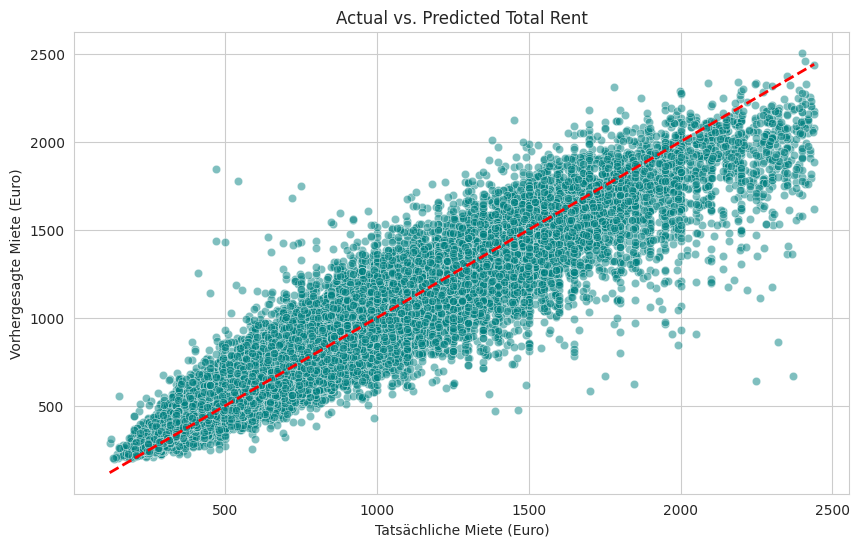

In [67]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)

plt.title('Actual vs. Predicted Total Rent')
plt.xlabel('Tatsächliche Miete (Euro)')
plt.ylabel('Vorhergesagte Miete (Euro)')
plt.grid(True)
plt.show()

***Residuen (Fehleranalyse)***

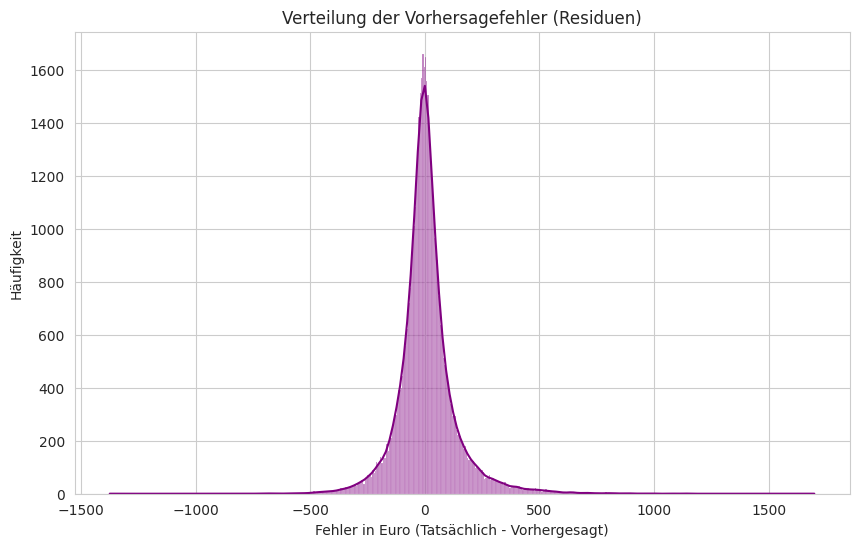

In [68]:
# Residuen sind die Differenz zwischen echtem Wert und Vorhersage.

plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
sns.histplot(residuals, kde=True, color='purple')

plt.title('Verteilung der Vorhersagefehler (Residuen)')
plt.xlabel('Fehler in Euro (Tatsächlich - Vorhergesagt)')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.show()

# Ein schmaler Peak um 0 zeigt, dass das Modell meistens richtig liegt.

***CHECK FOR OVERFITTING***

In [69]:
# Wir vergleichen Score auf Training vs. Test Set

train_score = final_model.score(X_train, y_train)
test_score = final_model.score(X_test, y_test)

print(f"📊 Training R²: {train_score:.4f}")
print(f"📊 Test R²:     {test_score:.4f}")
print(f"⚠️ Differenz:   {abs(train_score - test_score):.4f}")

# Wenn Differenz > 0.05, könnte Overfitting vorliegen.

📊 Training R²: 0.9179
📊 Test R²:     0.9023
⚠️ Differenz:   0.0157


***Crossvalidation***

In [70]:
from sklearn.model_selection import cross_val_score

# --- CROSS-VALIDATION (5-Fold) ---
# Validierung der Robustheit des Modells
cv_scores = cross_val_score(final_model, X, y, cv=5, scoring='r2')

print(f"✅ Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

✅ Mean CV R²: 0.9081 (+/- 0.0018)


***FEATURE IMPORTANCE (XGBoost)***

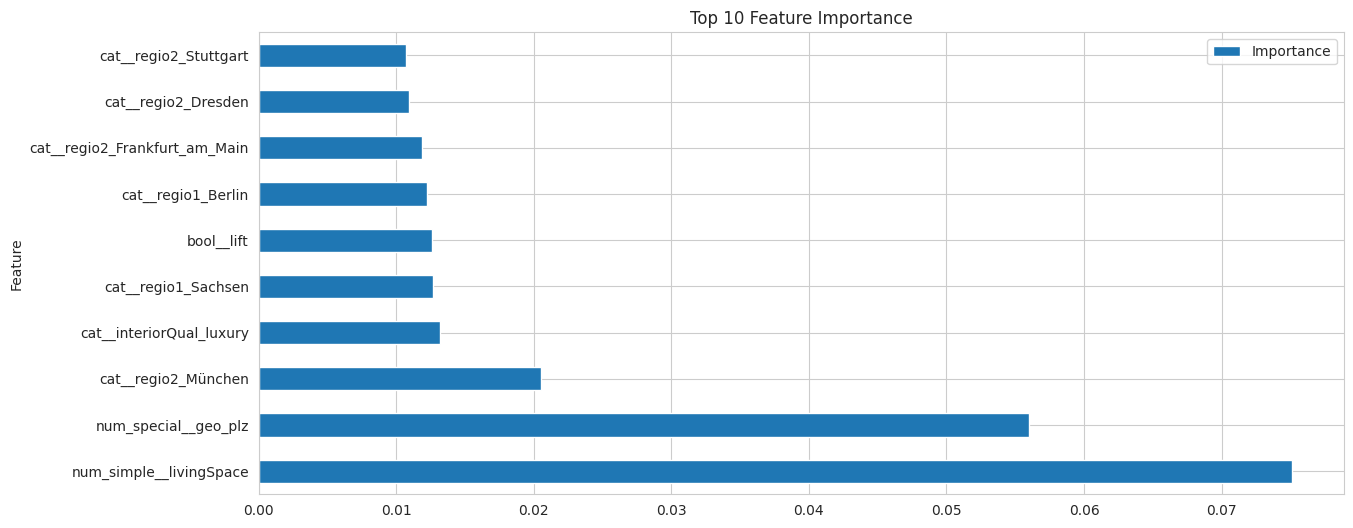

In [72]:
# Welche Merkmale treiben den Preis am stärksten?

# Wir holen den Regressor aus dem TransformedTargetRegressor
pipeline_inner = final_model.regressor_
xgb_model = pipeline_inner.named_steps['model']
importances = xgb_model.feature_importances_

# Visualisierung
# Die Feature-Namen müssen die Namen NACH der Vorverarbeitung sein
feature_names = pipeline_inner.named_steps['prep'].get_feature_names_out()

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False).head(10).plot(kind='barh', x='Feature')
plt.title("Top 10 Feature Importance")
plt.show()

***SHAP Interpretation (Post-Training Analysis)***

📊 SHAP Summary Plot: Einfluss der Merkmale auf die Mietpreis-Vorhersage


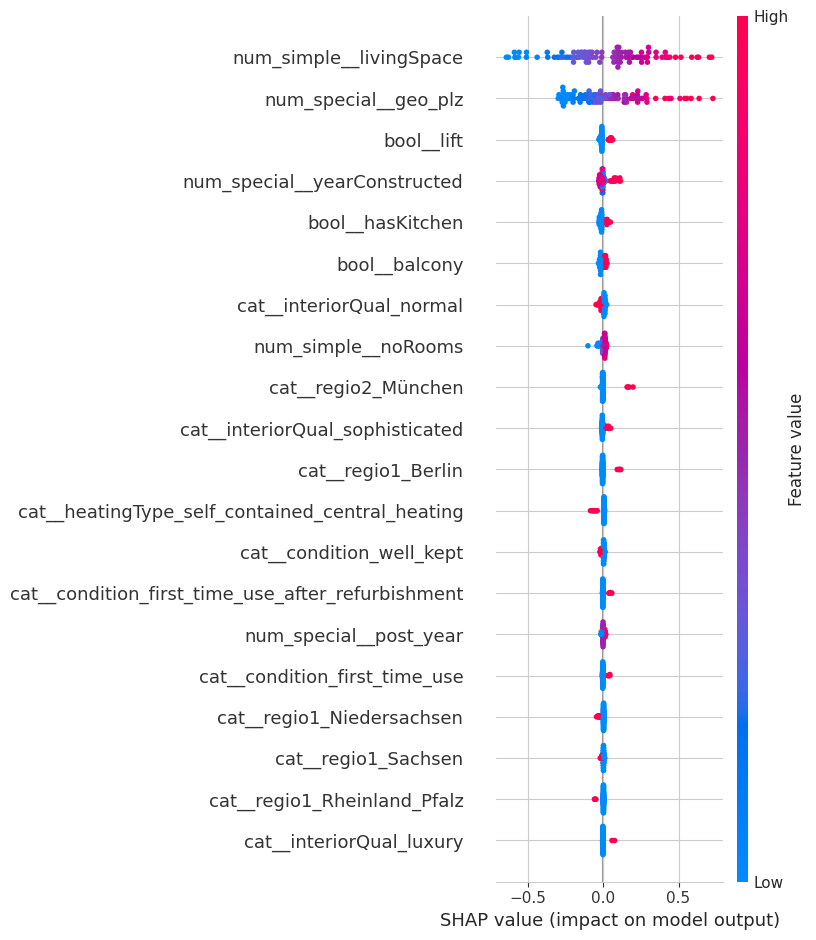

\n🏠 Einzelfall-Analyse für das erste Inserat:


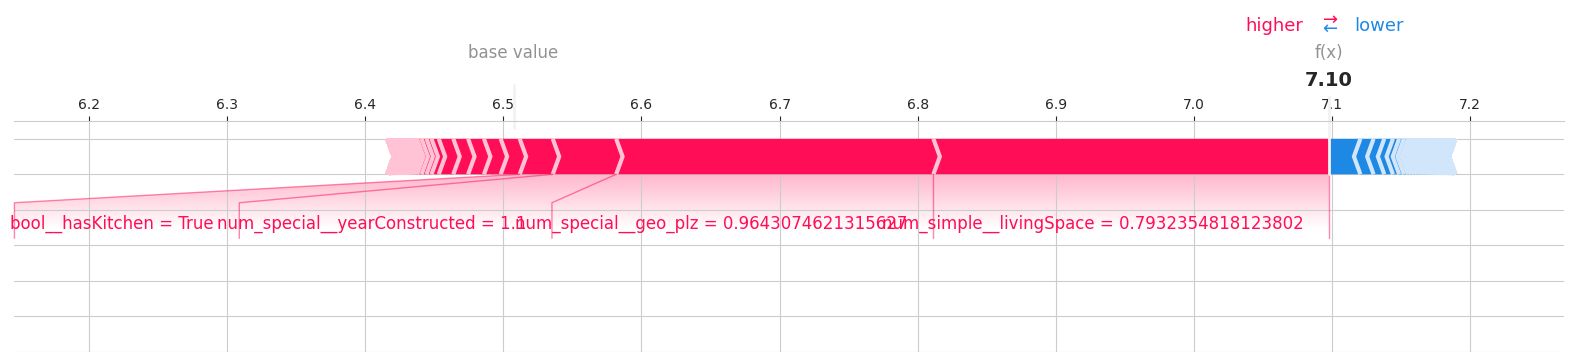

In [73]:
import shap
# ==============================================================================
# SHAP INTERPRETATION: ERKLÄRBARKEIT DES MODELLS (XAI)
# ==============================================================================

# 1. Extraktion des Regressors aus dem TransformedTargetRegressor Wrapper
# Wir brauchen die Pipeline, die innerhalb des Wrappers liegt.
pipeline_inner = final_model.regressor_

# 2. Daten-Vorverarbeitung für SHAP
# SHAP benötigt die Daten in dem Format, das direkt in den XGBoost-Algorithmus einfließt.
# Wir transformieren einen Teil des Test-Sets (z.B. 100 Samples für die Geschwindigkeit).
X_test_sample = X_test.head(100)
X_test_preprocessed = pipeline_inner.named_steps['prep'].transform(
    pipeline_inner.named_steps['plz_enc'].transform(
        pipeline_inner.named_steps['year_imp'].transform(
            pipeline_inner.named_steps['date_conv'].transform(X_test_sample)
        )
    )
)

# 3. Feature-Namen extrahieren
# Wir holen die Namen der Spalten nach dem One-Hot-Encoding und Scaling.
feature_names = pipeline_inner.named_steps['prep'].get_feature_names_out()

# 4. SHAP TreeExplainer initialisieren
# Da wir XGBoost nutzen, ist der TreeExplainer am effizientesten.
xgb_model = pipeline_inner.named_steps['model']
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_preprocessed)

# 5. Visualisierung: Summary Plot
# Dieser Plot zeigt, welche Features den Preis am stärksten beeinflussen.
print("📊 SHAP Summary Plot: Einfluss der Merkmale auf die Mietpreis-Vorhersage")
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names)

# 6. Einzelfall-Analyse (Force Plot für die erste Wohnung im Sample)
# Hier sieht man genau: Warum hat diese eine Wohnung genau diesen Preis bekommen?
shap.initjs()
print("\\n🏠 Einzelfall-Analyse für das erste Inserat:")
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_preprocessed[0,:], feature_names=feature_names, matplotlib=True)

***Learning Curves***

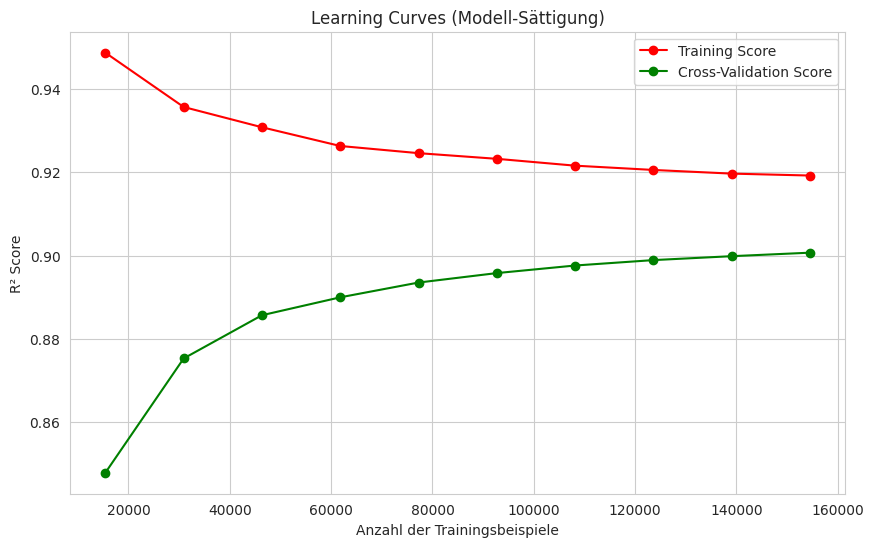

In [75]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# --- LEARNING CURVE ANALYSE ---
# Wir prüfen, ob das Modell von mehr Daten profitiert oder gesättigt ist.

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='r2'
    )

    # Mittelwerte und Standardabweichungen berechnen
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-Validation Score")

    plt.title("Learning Curves (Modell-Sättigung)")
    plt.xlabel("Anzahl der Trainingsbeispiele")
    plt.ylabel("R² Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Aufruf der Funktion (Achtung: Kann bei großen Daten etwas dauern)
plot_learning_curve(final_model, X_train, y_train)

 ANALYSE DER LERNKURVE (LEARNING CURVE INTERPRETATION)

Basierend auf dem Plot ziehen wir folgende Schlüsse für das Masterprojekt:

1. Konvergenz: Wenn sich die Linien annähern, ist das Modell gesättigt.
2. Gap: Ein kleiner Abstand deutet auf eine geringe Varianz (kein Overfitting) hin.
3. Plateau: Ein flacher Verlauf am Ende zeigt, dass mehr Daten das Ergebnis kaum noch verbessern würden.

In [ ]:
# ==============================================================================
# RESIDUAL-ANALYSE (FEHLERANALYSE)
# ==============================================================================
# Ein guter Regressor sollte Fehler (Residuen) haben, die zufällig um 0 verteilt sind.

plt.figure(figsize=(10, 6))
residuals = y_test - y_pred

# Scatterplot: Vorhersage vs. Fehler
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, color='darkorange')
plt.axhline(y=0, color='red', linestyle='--') # Nulllinie

plt.title('Residuen-Analyse (Homoskedastizität prüfen)')
plt.xlabel('Vorhergesagte Miete (Euro)')
plt.ylabel('Fehler (Tatsächlich - Vorhergesagt)')
plt.grid(True)
plt.show()

# Interpretation:
# Wenn die Punkte gleichmäßig um die rote Linie verteilt sind (ohne Trichterform),
# ist das Modell statistisch korrekt (Homoskedastizität).

# **Wassakh**

In [35]:
print(df_final['date'].unique()[:10])

['May19' 'Feb20' 'Oct19' 'Sep18']


In [40]:
# 1. Datentyp prüfen (In der Regel 'object', da es Text wie 'May19' ist)
print("Datentyp der Spalte 'date':", df_final['date'].dtype)

# 2. Die ersten 10 Einträge anzeigen, um das Format zu verstehen
print("\nErste 10 Einträge:")
print(df_final['date'].head(10))

# 3. Einzigartige Werte anzeigen (Wie viele verschiedene Zeitpunkte gibt es?)
print("\nAnzahl der einzigartigen Zeitpunkte:", df_final['date'].nunique())
print("Beispiele für Zeitpunkte:", df_final['date'].unique()[:5])

# 4. Verteilung der Daten (Wie viele Inserate pro Monat/Jahr?)
print("\nHäufigkeit der Inserate pro Datum (Top 5):")
print(df_final['date'].value_counts().head(5))

Datentyp der Spalte 'date': object

Erste 10 Einträge:
0     May19
1     May19
3     May19
4     Feb20
5     Feb20
6     Feb20
7     Feb20
8     Feb20
9     Oct19
10    Oct19
Name: date, dtype: object

Anzahl der einzigartigen Zeitpunkte: 4
Beispiele für Zeitpunkte: ['May19' 'Feb20' 'Oct19' 'Sep18']

Häufigkeit der Inserate pro Datum (Top 5):
date
Feb20    72602
May19    69243
Oct19    60777
Sep18    43047
Name: count, dtype: int64


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# مبيان توزيع سعر الكراء
sns.histplot(df_final['totalRent'], kde=True, color='blue')
plt.title('Verteilung der Gesamtmiete (Total Rent)')
plt.xlabel('Miete in Euro')
plt.ylabel('Häufigkeit')
plt.show()

KeyboardInterrupt: 

In [ ]:
# العلاقة بين المساحة وسعر الكراء
sns.scatterplot(data=df_clean, x='livingSpace', y='totalRent', alpha=0.5)
plt.title('Zusammenhang zwischen Wohnfläche und Miete')
plt.xlabel('Wohnfläche in m²')
plt.ylabel('Gesamtmiete in Euro')
plt.show()

# Test

# PLOT Funktion

In [ ]:
def plot_eda_summary(df):
    print("="*60)
    print("EXPLORATIVE DATENANALYSE (EDA)")
    print("="*60)

    # 1. Verteilung der Zielvariable (totalRent)
    # Zeigt uns, ob wir Ausreißer haben und wie die Preise verteilt sind
    plt.subplot(1, 2, 1)
    sns.histplot(df['totalRent'], bins=50, kde=True, color='skyblue')
    plt.title('Verteilung der Gesamtmiete (totalRent)')
    plt.xlabel('Miete (€)')
    plt.ylabel('Anzahl')

    # 2. Zusammenhang Wohnfläche vs. Miete
    # Das wichtigste Feature laut PDF
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=df['livingSpace'], y=df['totalRent'], alpha=0.3, color='darkblue')
    plt.title('Wohnfläche vs. Gesamtmiete')
    plt.xlabel('Wohnfläche (m²)')
    plt.ylabel('Miete (€)')

    plt.tight_layout()
    plt.show()

    # 3. Korrelations-Matrix (Nur numerische Features)
    # Zeigt, welche Features stark miteinander zusammenhängen
    plt.figure(figsize=(10, 8))
    numeric_cols = ['totalRent', 'livingSpace', 'noRooms', 'yearConstructed']
    corr_matrix = df[numeric_cols].corr()

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Korrelations-Matrix der wichtigsten numerischen Features')
    plt.show()

EXPLORATIVE DATENANALYSE (EDA)


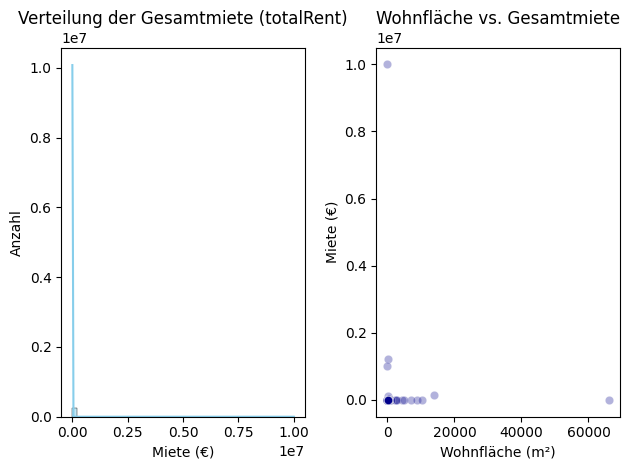

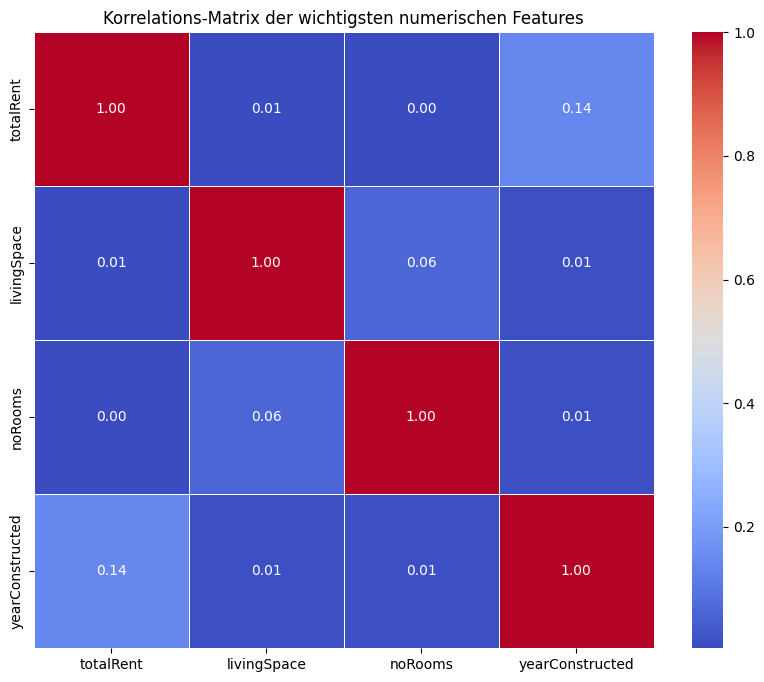

In [ ]:
# Run Visualization
plot_eda_summary(df_final)

Import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

Numeric

In [ ]:
# A. Numerische Pipeline (Skalierung)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Fallback falls GroupImputer was übersieht
    ('scaler', RobustScaler())
])

Katgorielle F

In [ ]:
# B. Kategorische Pipeline (Encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ColumnTransformer (Zusammenführung)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', 'passthrough', boolean_features) # Booleans sind schon 0/1
    ]
)

D. Die Haupt-Pipeline (Mit dem GroupImputer am Anfang!)

In [ ]:
main_pipeline = Pipeline(steps=[
    # Schritt 1: Baujahr schlau füllen (Vermeidet Leakage)
    ('year_fix', GroupMedianImputer(group_col='regio2', target_col='yearConstructed')),

    # Schritt 2: Skalieren & Encoden
    ('preprocessor', preprocessor),

    # Schritt 3: Das Modell (Beispiel XGBoost)
    # ('model', XGBRegressor())
])
print("✅ Pipeline erfolgreich definiert.")

# Plot 2

/tmp/ipython-input-667662734.py:99: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_dec, x='decade', y='price_sqm', hue='condition',
/tmp/ipython-input-667662734.py:160: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(muc, shade=True, color='red', label='München', ax=axes[4, 0])
/tmp/ipython-input-667662734.py:161: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(chem, shade=True, color='green', label='Chemnitz', ax=axes[4, 0])


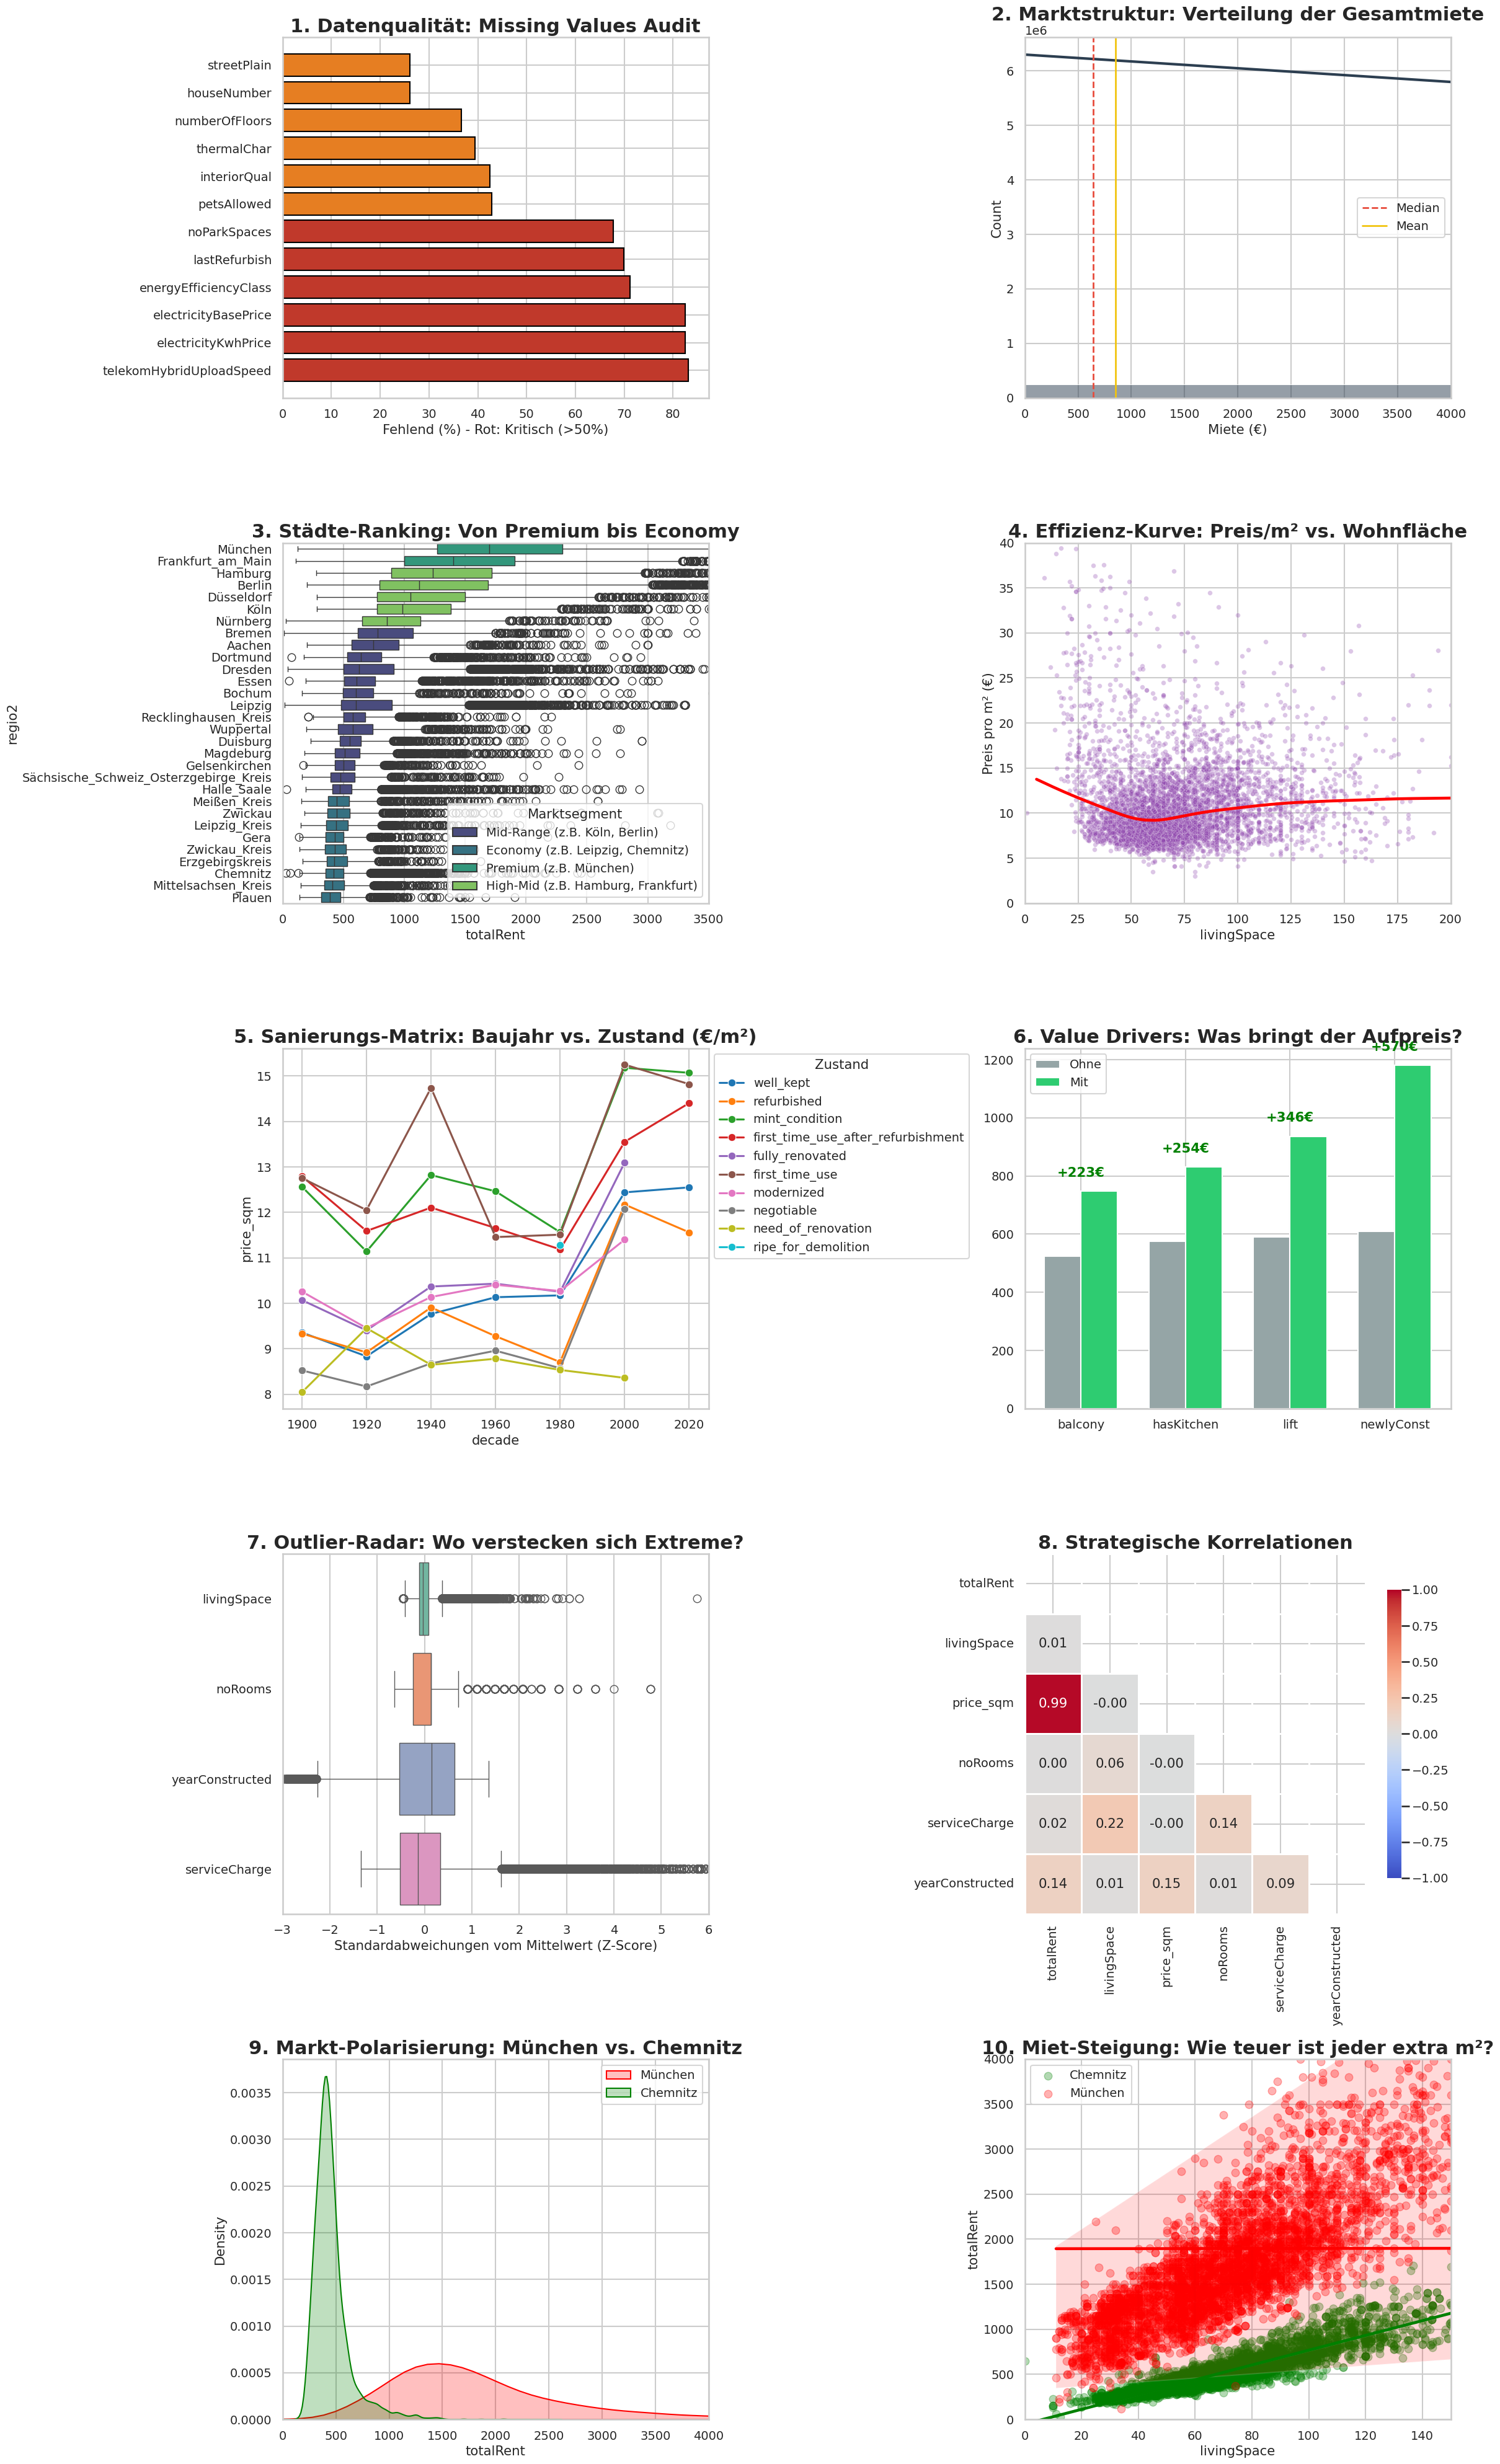

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- HIGH-END KONFIGURATION ---
sns.set_context("talk", font_scale=0.85)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (24, 40) # Extra lang für alle Details
plt.rcParams['font.family'] = 'sans-serif' # Sauberer Look

def run_ultimate_master_eda(df_input):
    """
    Master-Level EDA: Kombiniert statistische Tiefe mit Business-Insights.
    Fokus: Marktsegmentierung, Preistreiber und Ausreißer-Erkennung.
    """
    df_eda = df_input.copy()

    # --- Feature Engineering für die Analyse ---
    df_eda['price_sqm'] = df_eda['totalRent'] / df_eda['livingSpace']

    # Cluster-Logik für Städte (Statt nur "Budget")
    # Wir teilen die Top 30 Städte in Preis-Klassen
    top_cities = df_eda['regio2'].value_counts().head(30).index
    df_top = df_eda[df_eda['regio2'].isin(top_cities)].copy()

    city_medians = df_top.groupby('regio2')['price_sqm'].median()

    def classify_city(city):
        if city not in city_medians: return 'Andere'
        price = city_medians[city]
        if price > 18: return 'Premium (z.B. München)'
        elif price > 12: return 'High-Mid (z.B. Hamburg, Frankfurt)'
        elif price > 8: return 'Mid-Range (z.B. Köln, Berlin)'
        else: return 'Economy (z.B. Leipzig, Chemnitz)'

    df_top['City_Cluster'] = df_top['regio2'].apply(classify_city)

    # LAYOUT: 5 Zeilen, 2 Spalten
    fig, axes = plt.subplots(5, 2, figsize=(24, 40))
    plt.subplots_adjust(hspace=0.45, wspace=0.3)

    # ---------------------------------------------------------
    # 1. MISSING VALUES AUDIT (Severity Check)
    # ---------------------------------------------------------
    missing_pct = (df_eda.isnull().sum() / len(df_eda)) * 100
    missing_features = missing_pct[missing_pct > 0].sort_values(ascending=False).head(12)
    colors = ['#c0392b' if x > 50 else '#e67e22' if x > 10 else '#27ae60' for x in missing_features]

    axes[0, 0].barh(missing_features.index, missing_features.values, color=colors, edgecolor='black')
    axes[0, 0].set_title("1. Datenqualität: Missing Values Audit", fontsize=22, fontweight='bold')
    axes[0, 0].set_xlabel("Fehlend (%) - Rot: Kritisch (>50%)")

    # ---------------------------------------------------------
    # 2. TARGET DISTRIBUTION (Log-Scale Insight)
    # ---------------------------------------------------------
    # Zeigt Normalverteilung vs. Realität
    sns.histplot(df_eda['totalRent'], bins=80, kde=True, color='#2c3e50', ax=axes[0, 1], line_kws={'linewidth': 3})
    axes[0, 1].set_title("2. Marktstruktur: Verteilung der Gesamtmiete", fontsize=22, fontweight='bold')
    axes[0, 1].set_xlabel("Miete (€)")
    axes[0, 1].set_xlim(0, 4000)
    # Median & Mean einzeichnen
    axes[0, 1].axvline(df_eda['totalRent'].median(), color='#e74c3c', linestyle='--', linewidth=2, label='Median')
    axes[0, 1].axvline(df_eda['totalRent'].mean(), color='#f1c40f', linestyle='-', linewidth=2, label='Mean')
    axes[0, 1].legend()

    # ---------------------------------------------------------
    # 3. REGIONAL CLUSTERS (Das bessere Städte-Ranking)
    # ---------------------------------------------------------
    # Sortiert nach Median-Miete
    order = df_top.groupby('regio2')['totalRent'].median().sort_values(ascending=False).index

    sns.boxplot(y='regio2', x='totalRent', data=df_top, order=order,
                hue='City_Cluster', dodge=False, palette='viridis', ax=axes[1, 0])
    axes[1, 0].set_title("3. Städte-Ranking: Von Premium bis Economy", fontsize=22, fontweight='bold')
    axes[1, 0].set_xlim(0, 3500)
    axes[1, 0].legend(title='Marktsegment', loc='lower right')

    # ---------------------------------------------------------
    # 4. PRICE EFFICIENCY CURVE (Besser als Zimmer-Analyse)
    # ---------------------------------------------------------
    # Zeigt: Je kleiner die Wohnung, desto teurer der Quadratmeter
    sns.scatterplot(data=df_eda.sample(5000), x='livingSpace', y='price_sqm',
                    color='#8e44ad', alpha=0.3, s=30, ax=axes[1, 1])
    sns.regplot(data=df_eda.sample(5000), x='livingSpace', y='price_sqm',
                scatter=False, color='red', lowess=True, ax=axes[1, 1]) # Trendlinie
    axes[1, 1].set_title("4. Effizienz-Kurve: Preis/m² vs. Wohnfläche", fontsize=22, fontweight='bold')
    axes[1, 1].set_ylabel("Preis pro m² (€)")
    axes[1, 1].set_ylim(0, 40)
    axes[1, 1].set_xlim(0, 200)

    # ---------------------------------------------------------
    # 5. BAUJAHR & ZUSTAND (Sanierungseffekt)
    # ---------------------------------------------------------
    # Wir gruppieren Baujahre und prüfen den Einfluss des Zustands
    df_eda['decade'] = (df_eda['yearConstructed'] // 20) * 20
    df_dec = df_eda[(df_eda['yearConstructed'] > 1900) & (df_eda['yearConstructed'] < 2024)]

    sns.lineplot(data=df_dec, x='decade', y='price_sqm', hue='condition',
                 palette='tab10', marker='o', ci=None, ax=axes[2, 0])
    axes[2, 0].set_title("5. Sanierungs-Matrix: Baujahr vs. Zustand (€/m²)", fontsize=22, fontweight='bold')
    axes[2, 0].legend(bbox_to_anchor=(1, 1), loc='upper left', title='Zustand')

    # ---------------------------------------------------------
    # 6. FEATURE IMPACT (Extras: Balkon, Küche, Lift)
    # ---------------------------------------------------------
    features_bool = ['balcony', 'hasKitchen', 'lift', 'newlyConst']
    # Manuelles bauen des Plots für volle Kontrolle (Kein Melt-Fehler)
    pos = np.arange(len(features_bool))
    width = 0.35

    vals_yes = [df_eda[df_eda[f]==True]['totalRent'].median() for f in features_bool]
    vals_no = [df_eda[df_eda[f]==False]['totalRent'].median() for f in features_bool]

    axes[2, 1].bar(pos - width/2, vals_no, width, label='Ohne', color='#95a5a6')
    axes[2, 1].bar(pos + width/2, vals_yes, width, label='Mit', color='#2ecc71')

    # Beschriftung der Differenz
    for i, (y, n) in enumerate(zip(vals_yes, vals_no)):
        diff = y - n
        axes[2, 1].text(i, y + 50, f'+{diff:.0f}€', ha='center', fontweight='bold', color='green')

    axes[2, 1].set_xticks(pos)
    axes[2, 1].set_xticklabels(features_bool)
    axes[2, 1].set_title("6. Value Drivers: Was bringt der Aufpreis?", fontsize=22, fontweight='bold')
    axes[2, 1].legend()

    # ---------------------------------------------------------
    # 7. OUTLIER RADAR (Multi-Feature Boxplots)
    # ---------------------------------------------------------
    # Zeigt Ausreißer in allen wichtigen numerischen Features gleichzeitig
    feats_outlier = ['livingSpace', 'noRooms', 'yearConstructed', 'serviceCharge']
    # Daten normalisieren für den Plot (Min-Max Scaling) nur visuell
    df_norm = df_eda[feats_outlier].dropna()
    df_norm = (df_norm - df_norm.mean()) / df_norm.std()

    sns.boxplot(data=df_norm, orient='h', palette='Set2', ax=axes[3, 0])
    axes[3, 0].set_title("7. Outlier-Radar: Wo verstecken sich Extreme?", fontsize=22, fontweight='bold')
    axes[3, 0].set_xlabel("Standardabweichungen vom Mittelwert (Z-Score)")
    axes[3, 0].set_xlim(-3, 6) # Fokus auf den Bereich bis 6 Sigma

    # ---------------------------------------------------------
    # 8. CORRELATION DEEP DIVE (Top Features Only)
    # ---------------------------------------------------------
    cols_corr = ['totalRent', 'livingSpace', 'price_sqm', 'noRooms', 'serviceCharge', 'yearConstructed']
    corr = df_eda[cols_corr].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1,
                fmt=".2f", linewidths=1, ax=axes[3, 1], cbar_kws={"shrink": .8})
    axes[3, 1].set_title("8. Strategische Korrelationen", fontsize=22, fontweight='bold')

    # ---------------------------------------------------------
    # 9 & 10. MÜNCHEN vs. CHEMNITZ (Der extreme Vergleich)
    # ---------------------------------------------------------
    # Wir vergleichen direkt die Histogramme der teuersten vs. günstigsten Stadt
    muc = df_eda[df_eda['regio2'].str.contains('München', na=False)]['totalRent']
    chem = df_eda[df_eda['regio2'].str.contains('Chemnitz', na=False)]['totalRent']

    sns.kdeplot(muc, shade=True, color='red', label='München', ax=axes[4, 0])
    sns.kdeplot(chem, shade=True, color='green', label='Chemnitz', ax=axes[4, 0])
    axes[4, 0].set_title("9. Markt-Polarisierung: München vs. Chemnitz", fontsize=22, fontweight='bold')
    axes[4, 0].set_xlim(0, 4000)
    axes[4, 0].legend()

    # Scatterplot mit Regressionslinien für beide
    sns.regplot(x=df_eda[df_eda['regio2'].str.contains('Chemnitz', na=False)]['livingSpace'],
                y=chem, color='green', scatter_kws={'alpha':0.3}, label='Chemnitz', ax=axes[4, 1])
    sns.regplot(x=df_eda[df_eda['regio2'].str.contains('München', na=False)]['livingSpace'],
                y=muc, color='red', scatter_kws={'alpha':0.3}, label='München', ax=axes[4, 1])
    axes[4, 1].set_title("10. Miet-Steigung: Wie teuer ist jeder extra m²?", fontsize=22, fontweight='bold')
    axes[4, 1].set_xlim(0, 150); axes[4, 1].set_ylim(0, 4000)
    axes[4, 1].legend()

    plt.tight_layout()
    plt.show()

# Run High-End EDA
run_ultimate_master_eda(df_final)

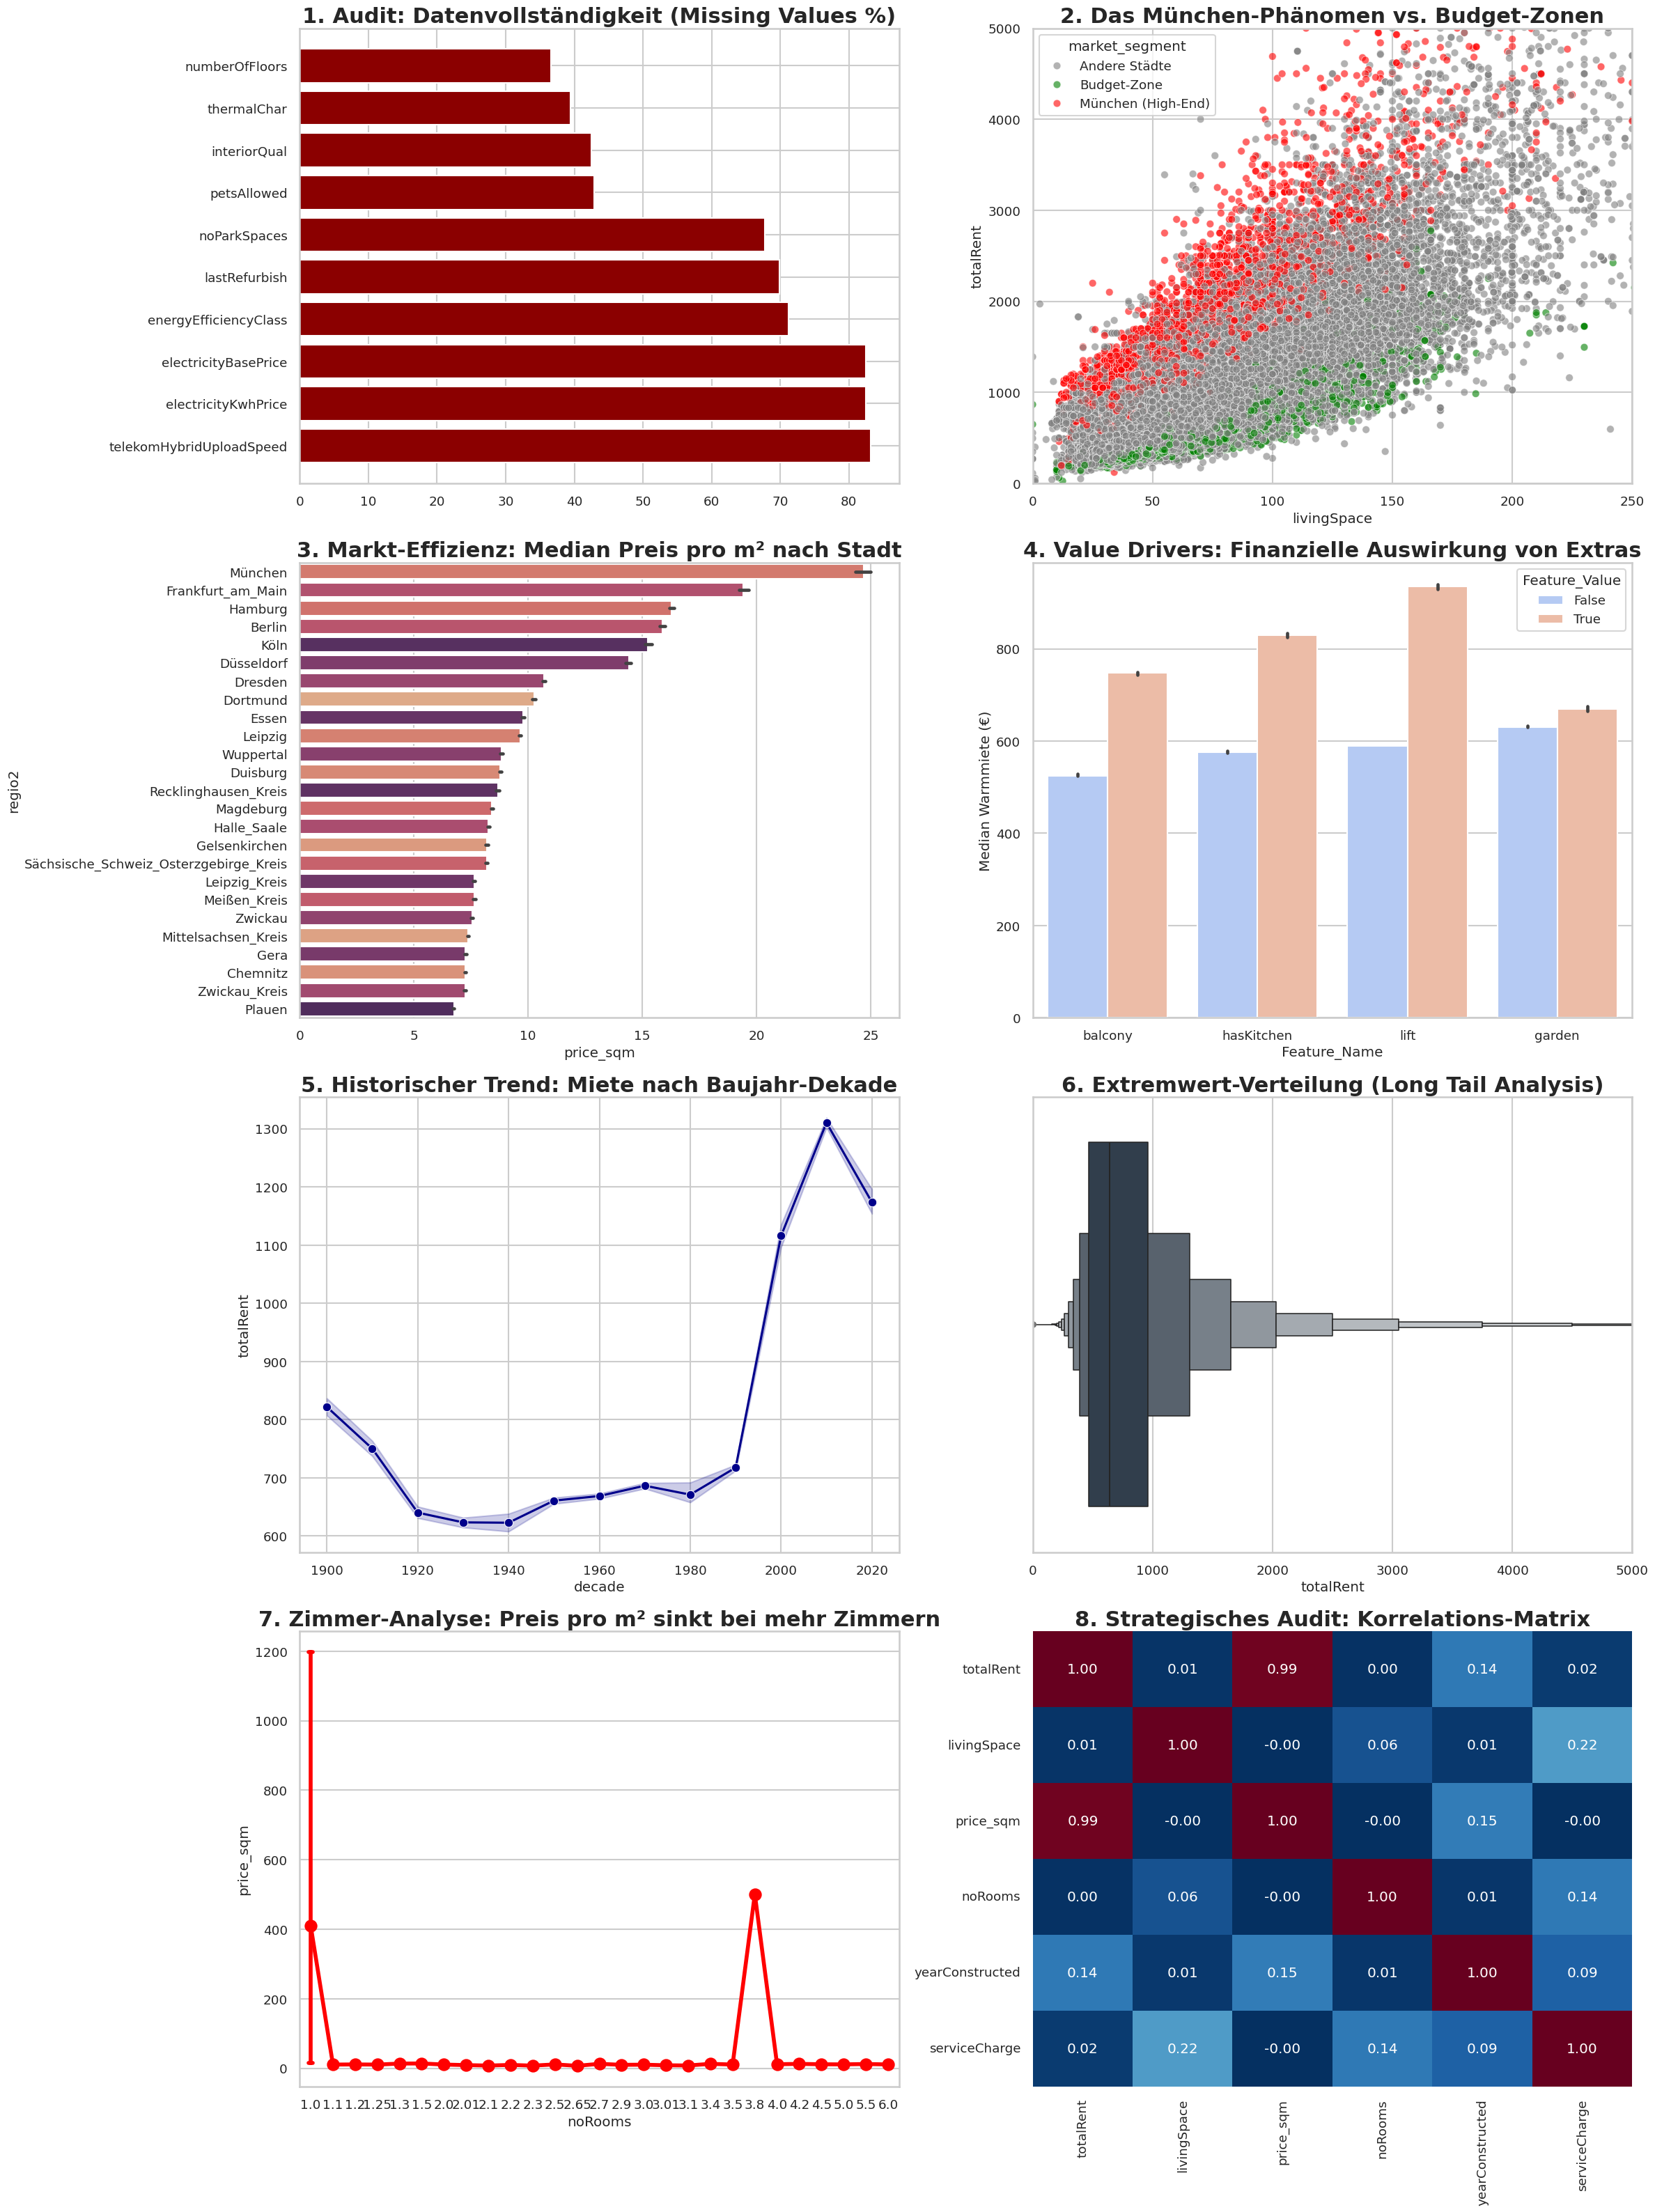

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Konfiguration: High-End Styling
sns.set_context("talk", font_scale=0.8)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (24, 35)

def run_ultimate_analyst_dashboard(df_input):
    """
    Expert-EDA Dashboard: Fokus auf München-Phänomen, Budget-Zonen und Feature-Impact.
    Behebt den Melt-Error und nutzt fortgeschrittene Visualisierungen. [cite: 71, 107]
    """
    df_eda = df_input.copy()

    # Feature Engineering: Die "Wahre" Währung (Preis pro m²) [cite: 927, 1010]
    df_eda['price_sqm'] = df_eda['totalRent'] / df_eda['livingSpace']

    # Identifizierung von Extremen (München vs. Budget-Hotspots) [cite: 933, 1056]
    top_cities = df_eda['regio2'].value_counts().head(25).index
    df_top = df_eda[df_eda['regio2'].isin(top_cities)].copy()

    # München markieren (Rot) und günstigste Stadt (z.B. Chemnitz/Magdeburg) markieren (Grün)
    def color_logic(city):
        if 'München' in str(city): return 'München (High-End)'
        if 'Chemnitz' in str(city) or 'Magdeburg' in str(city): return 'Budget-Zone'
        return 'Andere Städte'

    df_top['market_segment'] = df_top['regio2'].apply(color_logic)

    fig, axes = plt.subplots(4, 2, figsize=(24, 32))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # ---------------------------------------------------------
    # 1. MISSING VALUES AUDIT (Nach Prof. Wahl) [cite: 107, 388]
    # ---------------------------------------------------------
    missing_pct = (df_eda.isnull().sum() / len(df_eda)) * 100
    missing_features = missing_pct[missing_pct > 0].sort_values(ascending=False).head(10)
    colors_missing = ['darkred' if x > 20 else 'orange' for x in missing_features]
    axes[0, 0].barh(missing_features.index, missing_features.values, color=colors_missing)
    axes[0, 0].set_title("1. Audit: Datenvollständigkeit (Missing Values %)", fontsize=22, fontweight='bold')

    # ---------------------------------------------------------
    # 2. DAS MÜNCHEN-PHÄNOMEN (Scatter-Deep-Dive) [cite: 933, 1043]
    # ---------------------------------------------------------
    sns.scatterplot(data=df_top, x='livingSpace', y='totalRent', hue='market_segment',
                    palette={'München (High-End)': 'red', 'Budget-Zone': 'green', 'Andere Städte': 'grey'},
                    alpha=0.6, s=60, ax=axes[0, 1])
    axes[0, 1].set_title("2. Das München-Phänomen vs. Budget-Zonen", fontsize=22, fontweight='bold')
    axes[0, 1].set_xlim(0, 250); axes[0, 1].set_ylim(0, 5000)

    # ---------------------------------------------------------
    # 3. MIET-EFFIZIENZ: Preis/m² Ranking (Top 20 Städte) [cite: 936, 1258]
    # ---------------------------------------------------------
    order_sqm = df_top.groupby('regio2')['price_sqm'].median().sort_values(ascending=False).index
    sns.barplot(x='price_sqm', y='regio2', data=df_top, order=order_sqm, palette='flare',
                estimator=np.median, ax=axes[1, 0], hue='regio2', legend=False)
    axes[1, 0].set_title("3. Markt-Effizienz: Median Preis pro m² nach Stadt", fontsize=22, fontweight='bold')

    # ---------------------------------------------------------
    # 4. EXTRAS-IMPACT: Balkon, Lift, Garten, Küche [cite: 953, 1209]
    # ---------------------------------------------------------
    # FIX: Melt Error vermeiden durch explizite Namen
    features_bool = ['balcony', 'hasKitchen', 'lift', 'garden']
    df_melted = df_eda.melt(id_vars=['totalRent'], value_vars=features_bool,
                           var_name='Feature_Name', value_name='Feature_Value')

    sns.barplot(x='Feature_Name', y='totalRent', hue='Feature_Value', data=df_melted,
                palette='coolwarm', estimator=np.median, ax=axes[1, 1])
    axes[1, 1].set_title("4. Value Drivers: Finanzielle Auswirkung von Extras", fontsize=22, fontweight='bold')
    axes[1, 1].set_ylabel("Median Warmmiete (€)")

    # ---------------------------------------------------------
    # 5. BAUJAHR-DEKADEN: Der "Sanierungs"-Effekt [cite: 944, 1261]
    # ---------------------------------------------------------
    df_eda['decade'] = (df_eda['yearConstructed'] // 10) * 10
    df_decade = df_eda[(df_eda['yearConstructed'] > 1900) & (df_eda['yearConstructed'] < 2024)]
    sns.lineplot(data=df_decade, x='decade', y='totalRent', marker='o', color='darkblue', ax=axes[2, 0])
    axes[2, 0].set_title("5. Historischer Trend: Miete nach Baujahr-Dekade", fontsize=22, fontweight='bold')

    # ---------------------------------------------------------
    # 6. AUSREISSER-ANALYSE: totalRent Boxenplot [cite: 1033, 1145]
    # ---------------------------------------------------------
    sns.boxenplot(x=df_eda['totalRent'], color='#2c3e50', ax=axes[2, 1])
    axes[2, 1].set_title("6. Extremwert-Verteilung (Long Tail Analysis)", fontsize=22, fontweight='bold')
    axes[2, 1].set_xlim(0, 5000)

    # ---------------------------------------------------------
    # 7. ZIMMER-EFFIZIENZ (noRooms vs price_sqm) [cite: 931, 1012]
    # ---------------------------------------------------------
    sns.pointplot(x='noRooms', y='price_sqm', data=df_eda[df_eda['noRooms'] <= 6],
                  color='red', capsize=.2, ax=axes[3, 0])
    axes[3, 0].set_title("7. Zimmer-Analyse: Preis pro m² sinkt bei mehr Zimmern", fontsize=22, fontweight='bold')

    # ---------------------------------------------------------
    # 8. KORRELATIONS-MATRIX (Feature Selection Audit) [cite: 1208, 1240]
    # ---------------------------------------------------------
    corr_cols = ['totalRent', 'livingSpace', 'price_sqm', 'noRooms', 'yearConstructed', 'serviceCharge']
    corr = df_eda[corr_cols].corr()
    sns.heatmap(corr, annot=True, cmap='RdBu_r', fmt=".2f", ax=axes[3, 1], cbar=False)
    axes[3, 1].set_title("8. Strategisches Audit: Korrelations-Matrix", fontsize=22, fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- Run ---
run_ultimate_analyst_dashboard(df_final)

# kolhom

In [ ]:
# 1. Feature-Kategorien definieren
# Hier organisieren wir alle Spalten, um Leakage zu vermeiden und die Qualität zu prüfen.
feature_audit = {
    'LEAKAGE_DIREKT': [
        'baseRent',        # Grundmiete ist Teil der Zielvariable (totalRent)
        'serviceCharge',   # Nebenkosten sind Teil der Zielvariable
        'heatingCosts',    # Heizkosten sind Teil der Zielvariable
        'baseRentRange',   # Direkt von baseRent abgeleitet
    ],
    'LEAKAGE_ID': [
        'scoutId',         # Eindeutige ID ohne prädiktiven Wert
    ],
    'TEXT_FEATURES': [
        'description',     # Freitext erfordert NLP-Verarbeitung
        'facilities',      # Freitext erfordert NLP-Verarbeitung
    ],
    'GEO_FEATURES': [
        'regio1', 'regio2', 'regio3',
        'geo_bln', 'geo_krs', 'geo_plz',
        'street', 'streetPlain', 'houseNumber',
    ],
    'NUMERISCH_SICHER': [
        'livingSpace', 'noRooms', 'yearConstructed',
        'floor', 'numberOfFloors', 'picturecount',
        'thermalChar', 'noParkSpaces', 'pricetrend',
    ],
    'KATEGORISCH_SICHER': [
        'heatingType', 'condition', 'interiorQual',
        'typeOfFlat', 'petsAllowed', 'firingTypes', 'energyEfficiencyClass',
    ],
    'BOOLEAN_SICHER': [
        'balcony', 'lift', 'cellar', 'garden', 'hasKitchen', 'newlyConst',
    ],
    'DATUM': [
        'date', 'lastRefurbish',
    ],
    'TELEKOM_FEATURES': [
        'telekomTvOffer', 'telekomUploadSpeed', 'telekomHybridUploadSpeed',
    ],
    'SONSTIGE': [
        'noRoomsRange', 'livingSpaceRange', 'yearConstructedRange',
        'electricityBasePrice', 'electricityKwhPrice',
    ]
}

# 2. Report ausgeben
# Wir analysieren df_final auf Missing Values und Datentypen pro Kategorie.
print("="*80)
print(f"{'FEATURE-NAME':<30} | {'TYP':<12} | {'MISSING %'}")
print("="*80)

for category, features in feature_audit.items():
    print(f"\n--- {category} ---")
    for f in features:
        if f in df_final.columns:
            # Berechnung des Anteils fehlender Werte
            missing_pct = 100 * df_final[f].isna().sum() / len(df_final)
            dtype = str(df_final[f].dtype)
            print(f" • {f:30} | {dtype:12} | {missing_pct:5.1f}%")
        else:
            print(f" • {f:30} | {'NICHT VORHANDEN':<12} | -")# Feature-Audit: Überprüfung der Datenqualität und Identifizierung von Leakage
def run_enhanced_audit(df_to_check, audit_dict):
    """
    Diese Funktion analysiert die Spalten (Features) im Datensatz.
    Sie zeigt den Datentyp, den Anteil fehlender Werte und gibt Empfehlungen.
    """
    header = f"{'FEATURE-NAME':<30} | {'TYP':<12} | {'MISSING %':<12} | {'STATUS'}"
    print("=" * len(header))
    print(header)
    print("=" * len(header))

    for category, features in audit_dict.items():
        print(f"\n--- KATEGORIE: {category} ---")
        for f in features:
            if f in df_to_check.columns:
                # Berechnung der Fehlwerte in Prozent
                m_pct = 100 * df_to_check[f].isna().sum() / len(df_to_check)
                dtype = str(df_to_check[f].dtype)

                # Logik für den Status-Hinweis (Empfehlung)
                if category == 'LEAKAGE_DIREKT':
                    status = "❌ DROP (Leakage Risk)"
                elif category == 'LEAKAGE_ID':
                    status = "❌ DROP (Kein Vorhersagewert)"
                elif m_pct > 50:
                    status = "⚠️ KRITISCH (Hoher Missing-Anteil)"
                else:
                    status = "✅ OK"

                print(f" {f:<30} | {dtype:<12} | {m_pct:>8.2f}%   | {status}")
            else:
                # Falls die Spalte im aktuellen DataFrame nicht existiert
                print(f" {f:<30} | {'-':<12} | {'-':>9}   | ❓ NICHT IM DF")

# Aufruf der Funktion mit deinem df_final und dem definierten Feature-Audit
run_enhanced_audit(df_final, feature_audit)